In [23]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO

# ensemble csv files
submission_files = [
                   '/opt/ml/yolov5/ensemble/submission (5967).csv',
                   '/opt/ml/yolov5/ensemble/submission (6031).csv',
                   '/opt/ml/yolov5/ensemble/submission (6192).csv',
                   '/opt/ml/yolov5/ensemble/submission_latest.csv',
                   '/opt/ml/yolov5/ensemble/submission(6161).csv',
                   '/opt/ml/yolov5/ensemble/YoloV5x6__Create_Data.csv'] # submission lists
submission_df = [pd.read_csv(file) for file in submission_files]

image_ids = submission_df[0]['image_id'].tolist()

# ensemble 할 file의 image 정보를 불러오기 위한 json
annotation = '/opt/ml/detection/dataset/test.json'
coco = COCO(annotation)

prediction_strings = []
file_names = []



# ensemble 시 설정할 iou threshold 이 부분을 바꿔가며 대회 metric에 알맞게 적용해봐요!
iou_thr = 0.6
skip_box_thr = 0.0001
weights = [1,2,2,2,2,1]

# 각 image id 별로 submission file에서 box좌표 추출
for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
#     각 submission file 별로 prediction box좌표 불러오기
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
#     예측 box가 있다면 이를 ensemble 수행

    if len(boxes_list):
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list,weights=weights ,iou_thr=iou_thr,skip_box_thr=skip_box_thr)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

    submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('submission_ensemble_4.csv',index=None)

submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


KeyboardInterrupt: 

test/0001.jpg


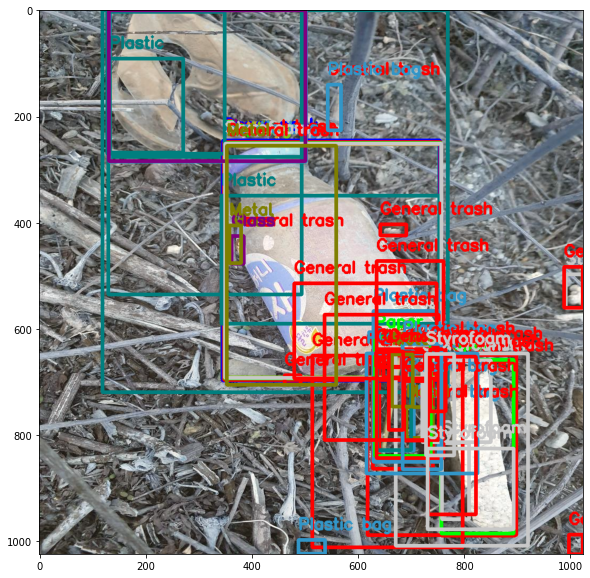

In [21]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import matplotlib.pyplot as plt

# class 별 bbox 색
colors = [
    (255, 0, 0), 
    (0, 255, 0),
    (0, 0, 255),
    (127, 127, 0),
    (127, 0, 127),
    (0, 127, 127),
    (200, 200, 200),
    (50, 150, 200),
    (200, 155, 50),
    (130, 198, 20),
]
labels = {0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}

# 이미지 경로
img_dir = '/opt/ml/detection/dataset/'
# output 파일 경로
output_dir = '/opt/ml/yolov5/ensemble/submission_ensemble_3.csv'
# output_dir = '/opt/ml/detection/dataset/train.json'

test_result = pd.read_csv(output_dir)

file_names = test_result['image_id'].values.tolist()
bboxes = test_result['PredictionString'].values.tolist()

idx = 1
# idx = 13
file_name = file_names[idx]
print(file_name)
bbox = bboxes[idx].split()

image = cv2.imread(os.path.join(img_dir, file_name)).astype(np.uint8)
for i in range(0, len(bbox), 6):
    label = int(bbox[i])
    x_min = int(bbox[i + 2].split('.')[0])
    y_min = int(bbox[i + 3].split('.')[0])
    x_max = int(bbox[i + 4].split('.')[0])
    y_max = int(bbox[i + 5].split('.')[0])
    
    # bounding box 그리기
    image = cv2.rectangle(image, pt1=(x_min, y_min), pt2=(x_max, y_max), color=colors[label], thickness=5)
    # label text 넣기
    cv2.putText(image, labels[label], (x_min, y_min - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[label], 3)

plt.figure(figsize=(10,10))
plt.imshow(image)